# Rat LPS VAMPIRE Data Analysis

Teng-Jui Lin

Created: 2022-05-23

Edited: 2022-10-04

Objective: Analyze data obtained from VAMPIRE analysis for rat LPS model.

## Import VAMPIRE analysis data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import vampire as vp
from sklearn import manifold

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
vp.plot.set_plot_style()

In [3]:
output_path = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/4-vampire-analysis-data'
model_path = os.path.join(output_path, 'model_rat-lps_(50_5_30)__.pickle')
vampire_model = vp.util.read_pickle(model_path)
property_path = os.path.join(output_path, 'apply-properties_rat-lps_on_rat-lps_(50_5_30)__.pickle')
apply_properties_df = vp.util.read_pickle(property_path)

## Data processing

### Label experimental metadata

In [4]:
apply_properties_df.head()

,filename,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,perimeter,...,eccentricity,solidity,extent,raw_contour,circularity,aspect_ratio,normalized_contour,cluster_id,plot_cluster_id,distance_to_centroid
0,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,1,84.900000,1302.300000,280,525,373,280,104.947222,...,0.669402,0.750670,0.533333,"[[8, 9, 10, 9, 9, 9, 10, 11, 12, 13, 14, 15, 1...",0.319467,1.346075,"[1.3230204909947774, 1.1664498891688428, 1.099...",4,5,0.831152
1,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,2,94.152113,159.977465,355,594,500,355,134.260931,...,0.603369,0.710000,0.597643,"[[10, 11, 12, 13, 12, 13, 12, 11, 10, 11, 12, ...",0.247479,1.253977,"[1.2748219985930247, 1.1433577237455894, 0.932...",3,4,0.907481
2,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,3,140.586331,1296.607914,278,684,402,278,96.976659,...,0.937790,0.691542,0.406433,"[[15, 16, 17, 16, 16, 16, 16, 15, 16, 16, 15, ...",0.371467,2.880162,"[1.6512608519013772, 1.4951633868765175, 1.394...",1,2,0.655149
3,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,4,129.236842,1231.164474,152,360,246,152,80.876154,...,0.904480,0.617886,0.422222,"[[5, 6, 7, 8, 7, 8, 9, 10, 11, 12, 13, 14, 14,...",0.292020,2.344578,"[1.4486842616575322, 1.2915738612761847, 1.267...",1,2,0.760685
4,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,5,191.035496,1284.299878,817,1666,1188,817,172.823376,...,0.753969,0.687710,0.490396,"[[22, 23, 23, 23, 22, 23, 24, 25, 26, 27, 28, ...",0.343738,1.522280,"[0.8087985578964927, 0.7044341866786972, 0.734...",2,3,0.913368


In [5]:
def label_df(properties_df, id_df, target_props, search_prop='filename'):
    """
    properties_df : DataFrame
        Contains "filename" column
    id_df : DataFrame
        Contains columns listed in `properties` and "regex" column.
    target_props : list
        List of property(s) to be added. Must match column name in `id_df`.
    """
    properties_df = properties_df.copy()
    properties_df[target_props] = np.nan
    for i in range(id_df['regex'].size):
        mask = properties_df[search_prop].astype(str).str.contains(id_df['regex'][i])
        properties_df.loc[mask, target_props] = id_df.iloc[i, :][target_props].values
    return properties_df

In [6]:
treatment_id_df = pd.read_excel(r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/3-data-labels/treatment-labels.xlsx')
treatment_id_df.head()

,id,treatment,regex
0,LPS_1ug,LPS 1 ug,LPS_1ug(?!_serum)
1,LPS_100ng,LPS 0.1 ug,LPS_100ng
2,NT,NC,NT(?!_serum)
3,LPS_1ug_serum,LPS 1 ug + Serum,LPS_1ug_serum
4,LPS_10ug,LPS 10 ug,LPS_10ug


In [7]:
treatment_time_id_df = pd.read_excel(r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/3-data-labels/treatment-time-labels.xlsx')
treatment_time_id_df.head()

,id,treatment_time,regex
0,24h,24 h,24h
1,72h,72 h,72h


In [8]:
other_time_id_df = pd.read_excel(r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/3-data-labels/other-time-labels.xlsx')
other_time_id_df.head()

,id,other_time,regex
0,-3-,-3,-3-
1,0-,0,^((?!-3-).)*$


In [9]:
apply_properties_df = label_df(apply_properties_df, treatment_id_df, ['treatment'])
apply_properties_df = label_df(apply_properties_df, treatment_time_id_df, ['treatment_time'])
apply_properties_df = label_df(apply_properties_df, other_time_id_df, ['other_time'])
vp.util.write_pickle(os.path.join(output_path, 'labeled-apply-properties_rat-lps_on_rat-lps_(50_5_30)__.pickle'), apply_properties_df)
apply_properties_df

/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_2408/4201282033.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = properties_df[search_prop].astype(str).str.contains(id_df['regex'][i])


,filename,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,perimeter,...,raw_contour,circularity,aspect_ratio,normalized_contour,cluster_id,plot_cluster_id,distance_to_centroid,treatment,treatment_time,other_time
0,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,1,84.900000,1302.300000,280,525,373,280,104.947222,...,"[[8, 9, 10, 9, 9, 9, 10, 11, 12, 13, 14, 15, 1...",0.319467,1.346075,"[1.3230204909947774, 1.1664498891688428, 1.099...",4,5,0.831152,LPS 0.1 ug,24 h,0.0
1,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,2,94.152113,159.977465,355,594,500,355,134.260931,...,"[[10, 11, 12, 13, 12, 13, 12, 11, 10, 11, 12, ...",0.247479,1.253977,"[1.2748219985930247, 1.1433577237455894, 0.932...",3,4,0.907481,LPS 0.1 ug,24 h,0.0
2,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,3,140.586331,1296.607914,278,684,402,278,96.976659,...,"[[15, 16, 17, 16, 16, 16, 16, 15, 16, 16, 15, ...",0.371467,2.880162,"[1.6512608519013772, 1.4951633868765175, 1.394...",1,2,0.655149,LPS 0.1 ug,24 h,0.0
3,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,4,129.236842,1231.164474,152,360,246,152,80.876154,...,"[[5, 6, 7, 8, 7, 8, 9, 10, 11, 12, 13, 14, 14,...",0.292020,2.344578,"[1.4486842616575322, 1.2915738612761847, 1.267...",1,2,0.760685,LPS 0.1 ug,24 h,0.0
4,2019-02-18_DAPI_Iba_LPS_100ng_0-24_24h_60x_sca...,0,5,191.035496,1284.299878,817,1666,1188,817,172.823376,...,"[[22, 23, 23, 23, 22, 23, 24, 25, 26, 27, 28, ...",0.343738,1.522280,"[0.8087985578964927, 0.7044341866786972, 0.734...",2,3,0.913368,LPS 0.1 ug,24 h,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2019-02-18_DAPI_Iba_LPS_1ug_0-24_24h_60x_scan_...,32,71,1386.167702,1364.273292,161,360,278,161,79.734019,...,"[[3, 4, 5, 6, 5, 5, 6, 7, 8, 9, 10, 10, 10, 10...",0.318235,1.326119,"[1.4040265583387201, 1.2071217068078577, 1.015...",4,5,0.902976,LPS 1 ug,24 h,0.0
1056,2019-02-18_DAPI_Iba_LPS_1ug_0-24_24h_60x_scan_...,32,72,1408.429952,658.439614,207,418,281,207,81.355339,...,"[[6, 5, 6, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14...",0.393014,1.346485,"[1.067246937143048, 1.1280375516603323, 1.0398...",4,5,0.853173,LPS 1 ug,24 h,0.0
1057,2019-02-18_DAPI_Iba_LPS_1ug_0-24_24h_60x_scan_...,32,73,1444.747500,135.615000,800,1178,853,800,115.053824,...,"[[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...",0.759447,1.196790,"[1.1426593844405935, 1.0581282293591612, 1.006...",4,5,0.465190,LPS 1 ug,24 h,0.0
1058,2019-02-25_NT_24h_60x_scan_2_otsu_thresh.tif,33,1,289.716535,1183.429134,254,663,493,254,140.089358,...,"[[6, 7, 7, 6, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13...",0.162642,2.734496,"[1.5768934903172342, 1.3237192901715706, 1.179...",1,2,0.863175,NC,24 h,0.0


### Label cluster coloring

In [10]:
from matplotlib.colors import to_hex
color_id_df = pd.DataFrame({
    'plot_cluster_id': [1, 2, 3, 4, 5],
    'color': [to_hex(plt.get_cmap('twilight')(np.linspace(0.1, 0.9, 5))[i]) for i in range(5)],
})
color_id_df['regex'] = color_id_df['plot_cluster_id'].astype(str)

In [11]:
label_colors = label_df(apply_properties_df, color_id_df, ['color'], 'plot_cluster_id').color.values
label_colors

array(['#d0b39e', '#9f3c50', '#5f58b0', ..., '#d0b39e', '#5f58b0',
       '#d0b39e'], dtype=object)

In [42]:
[to_hex(plt.get_cmap('twilight')(np.linspace(0.1, 0.9, 5))[i]) for i in range(5)],

(['#a6bfca', '#5f58b0', '#2f1436', '#9f3c50', '#d0b39e'],)

## Visualization of data

### Number of microglia in each group

<AxesSubplot:>

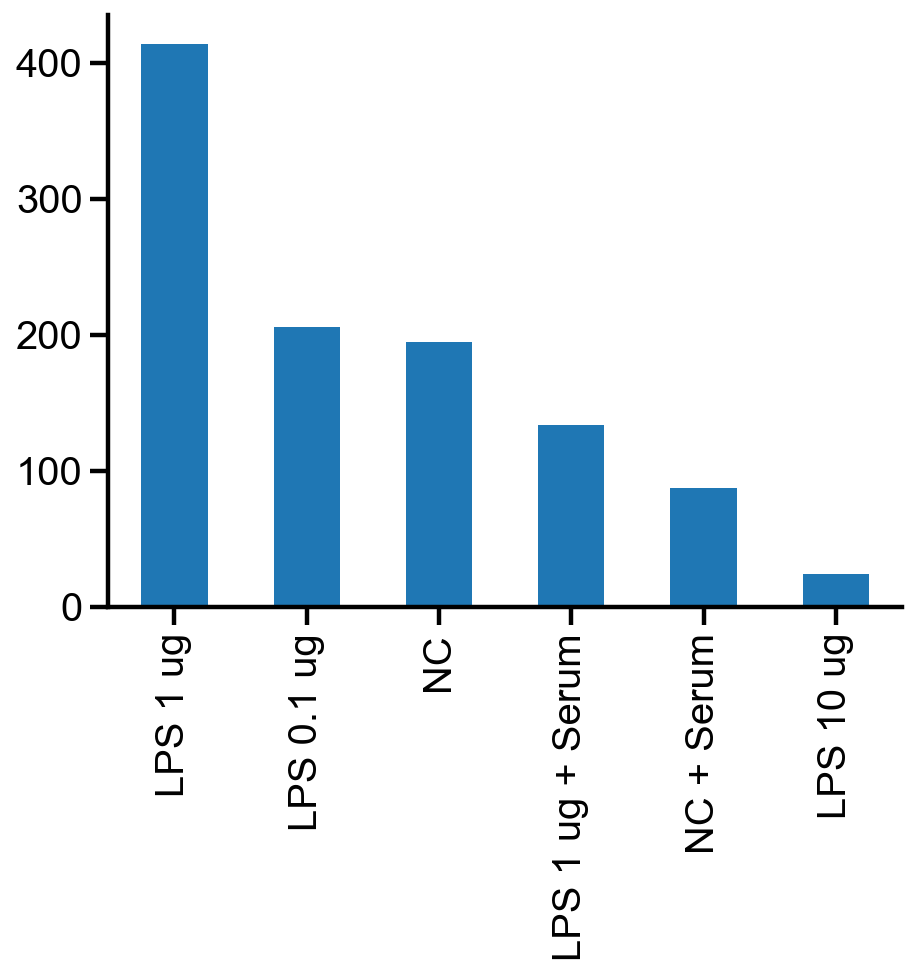

In [12]:
apply_properties_df['treatment'].value_counts().plot(kind='bar')

<AxesSubplot:>

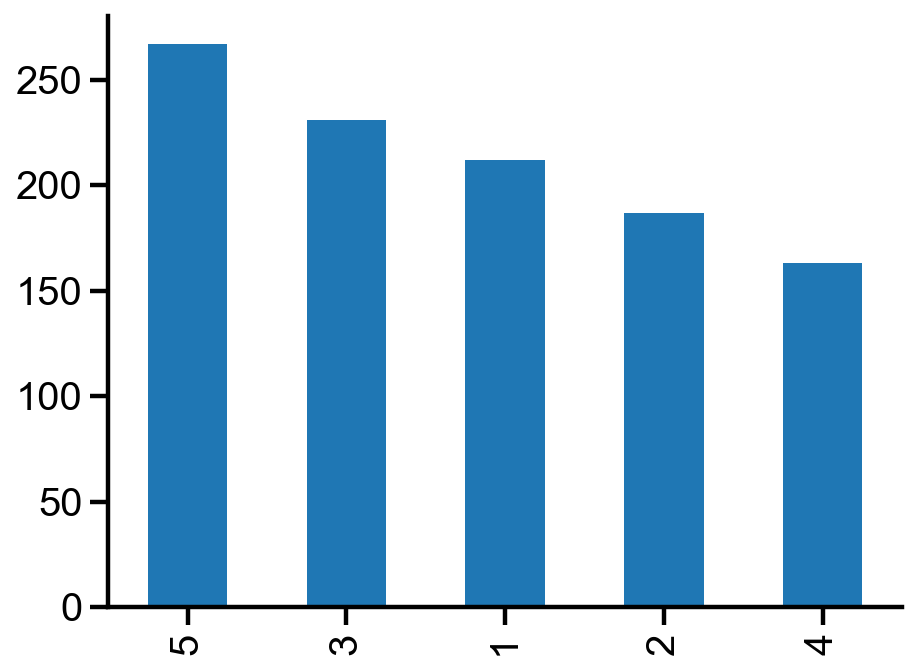

In [13]:
apply_properties_df['plot_cluster_id'].value_counts().plot(kind='bar')  # shape mode distribution

### Creating DataFrames for GraphPad Prism Visualization

The resulting DataFrames are saved into csv that can be imported to GraphPad Prism for statistical analysis and visualization.

#### Categorical scatterplot of (morphological parameter) vs. (category)

In [14]:
reshaped_data_output = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-lps/5-reshaped-data'
properties = ['area', 'perimeter', 'circularity', 'aspect_ratio', 'solidity', 'eccentricity', 'extent', 'distance_to_centroid']

In [15]:
def get_categorical_df(input_df, feature, category):
    """
    Create DataFrame for GraphPad Prism "column table" visualization of categorical scatter plots.
    Numerical feature vs. catagorical variable.
    
    input_df : DataFrame
        Contains `feature` and `category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    """
    category_items = np.unique(input_df[category])
    data = [input_df[(input_df[category] == i)]
            [feature].reset_index(drop=True) 
            for i in category_items]
    df = pd.concat(data, axis=1)
    df.columns = category_items
    return df

In [16]:
# categorical scatterplot of (morphological parameter) vs. (category)
# one plot for each (morphological parameter)
for prop in properties:
    get_categorical_df(
        apply_properties_df, 
        prop, 
        'plot_cluster_id'
    ).to_csv(
        os.path.join(reshaped_data_output, rf'cat-scat_{prop}-vs-cluster-_all_treatment_all_regions.csv'), 
        index=False
    )

#### Categorical scatterplot of (morphological parameter) vs. (category) with (controlled category)

In [17]:
def get_controlled_categorical_dfs(input_df, feature, category, controlled_category):
    """
    Create DataFrames for GraphPad Prism "column table" visualization of grouped categorical scatter plots.
    Numerical feature vs. catagorical variable with one categorical variable controlled.
    
    input_df : DataFrame
        Contains `feature` and `category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    """
    category_items = np.unique(input_df[category])
    controlled_category_items = np.unique(input_df[controlled_category])
    dfs = []
    for controlled_category_item in controlled_category_items:
        data = [input_df[(input_df[category] == i)]
                [input_df[(input_df[category] == i)][controlled_category] == controlled_category_item]
                [feature].reset_index(drop=True) 
                for i in category_items]
        df = pd.concat(data, axis=1)
        df.columns = category_items
        dfs.append(df)
    return dfs

In [18]:
# categorical scatterplots of (morphological parameter) vs. (category) with (controlled category)
# for prop in properties:
    # get_controlled_categorical_dfs(apply_properties_df, prop, 'region', 'plot_cluster_id')

#### Heatmap of (morphological parameter) with (category) vs. (controlled category)

In [19]:
def get_heatmap_df(input_df, feature, category, controlled_category, statistics='median'):
    """
    Create DataFrame for GraphPad Prism "contingency tables" visualization of heatmap.
    Categorical variable vs. catagorical variable of heatmap of numerical feature.
    
    input_df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    statistics : str, optional
        Statistical parameter of interest. Default "median".
    """
    return pd.pivot_table(input_df.groupby(by=[category, controlled_category]).agg(statistics),
                                           values=feature,
                                           index=[category],
                                           columns=[controlled_category])

In [20]:
get_heatmap_df(apply_properties_df, 'circularity', 'treatment', 'plot_cluster_id')

plot_cluster_id,1,2,3,4,5
treatment,,,,,
LPS 0.1 ug,0.261495,0.266378,0.227928,0.293346,0.420576
LPS 1 ug,0.228845,0.237263,0.216725,0.302263,0.485072
LPS 1 ug + Serum,0.310501,0.249326,0.223138,0.307981,0.438605
LPS 10 ug,0.265921,0.267054,0.457684,0.323802,0.643586
NC,0.223052,0.207775,0.218761,0.328964,0.410613
NC + Serum,0.177053,0.254445,0.305520,0.338549,0.538418


The resulting DataFrame can be used for heatmap visualization in both GraphPad Prism and Python. Here, we demonstrate visualization using Python.

### Population trend of morphological parameters

#### Treatment vs. cluster

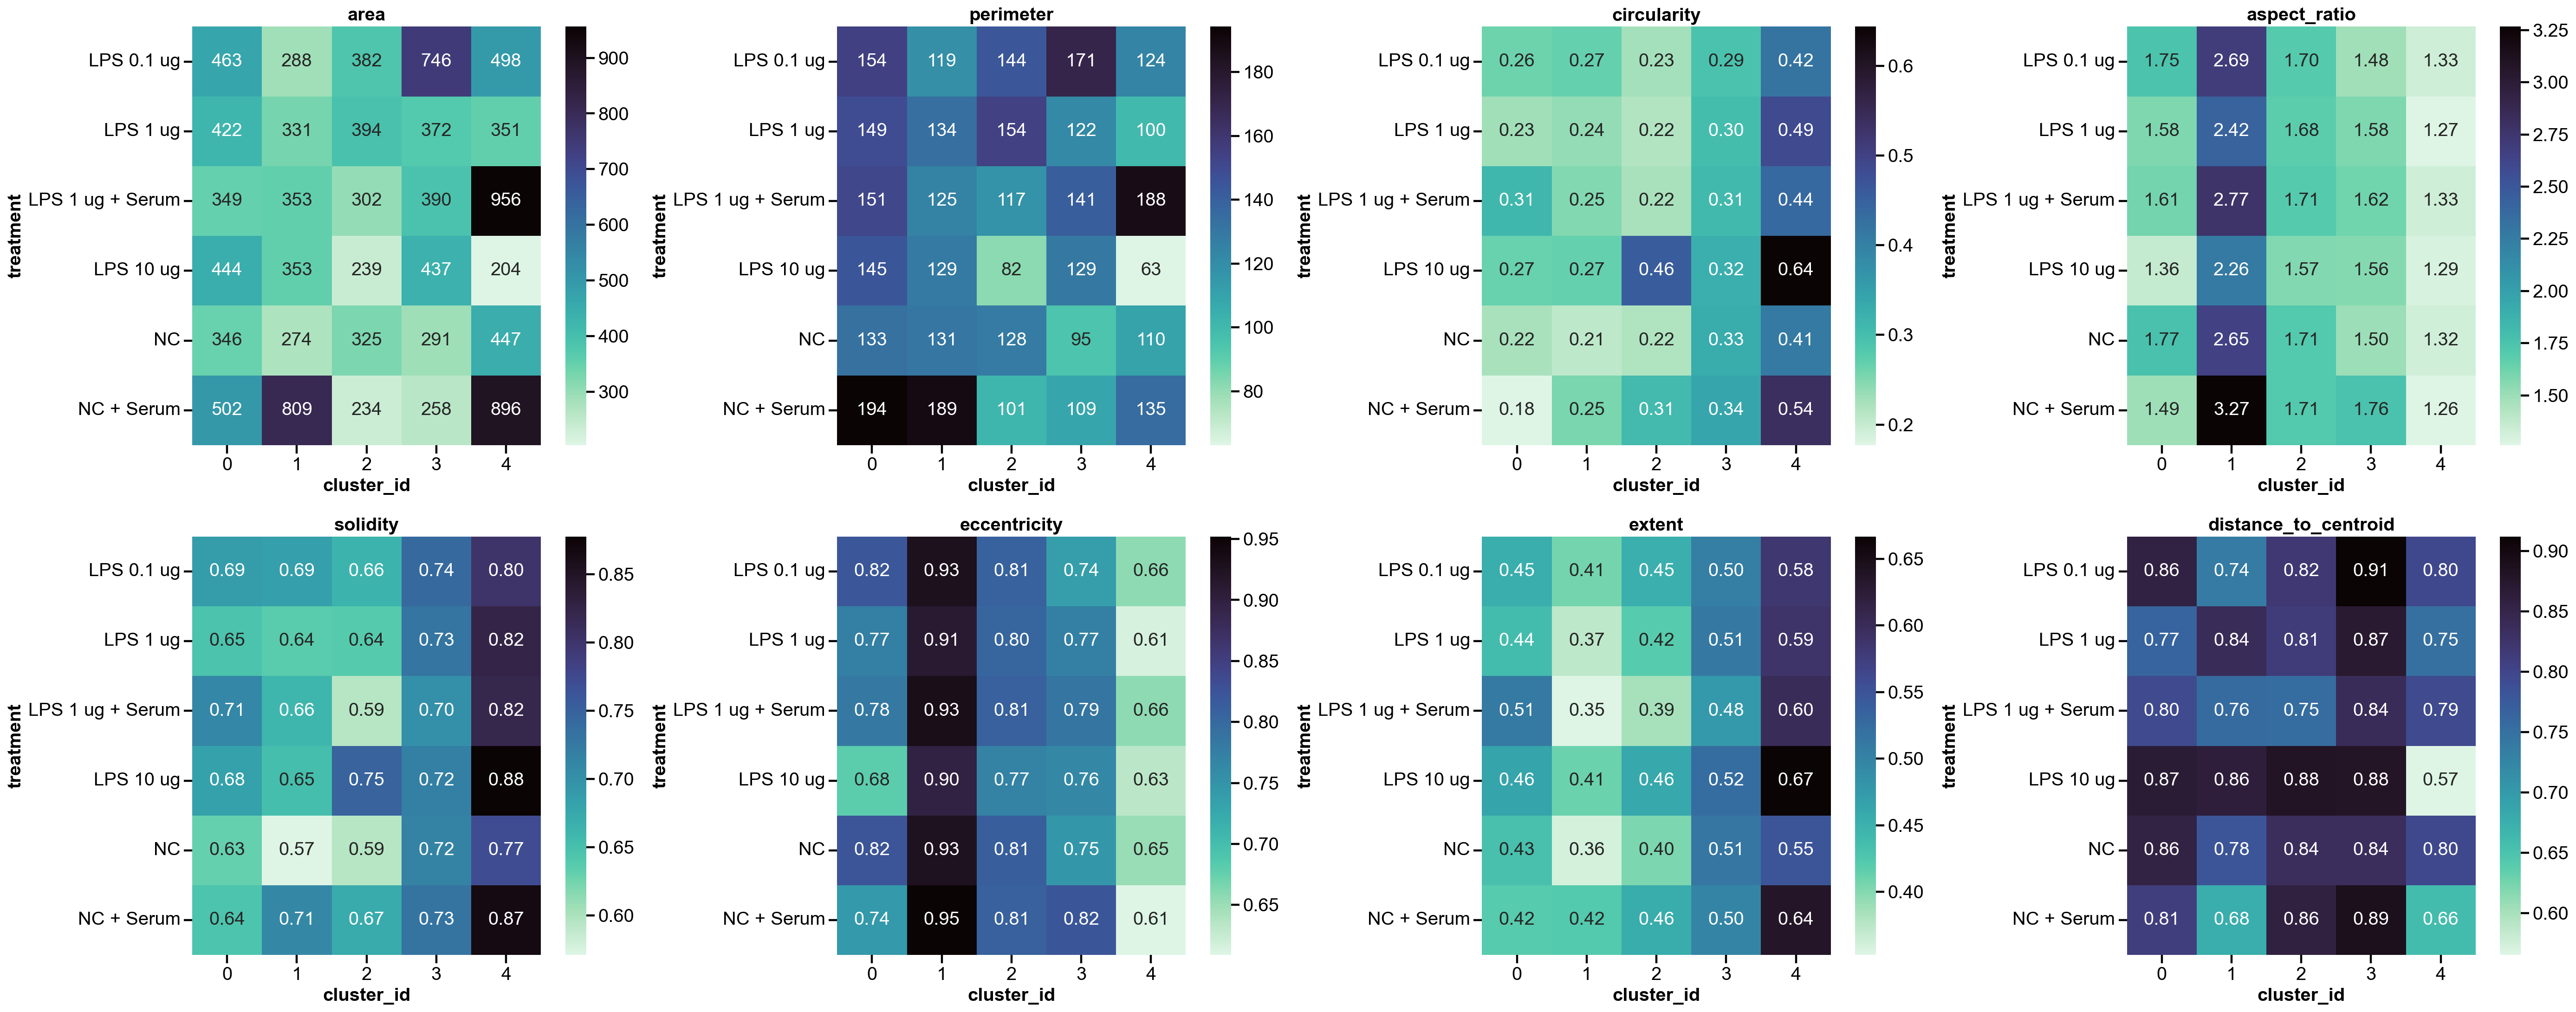

In [21]:
col = 4
row = 2
scale = 7

fig, axs = plt.subplots(row, col, figsize=((col+1)*scale, row*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            heatmap_df = get_heatmap_df(apply_properties_df, properties[i], 'treatment', 'cluster_id')
            if heatmap_df.max().max() > 10:
                fmt = '.0f'
            else:
                fmt = '.2f'
                
            sns.heatmap(heatmap_df,
                        square=True,
                        annot=True,
                        fmt=fmt,
                        ax=axs[row_i, col_i],
                        cmap='mako_r')
            axs[row_i, col_i].set_title(properties[i])
plt.tight_layout()

### Changes of morphological parameters

#### Functions for plotting changes

In [22]:
def compute_arrow(df, feature, category, category_item,
                  controlled_category, init_controlled_category, final_controlled_category):
    """
    Calculate the initial y value of arrow and the length of the arrow.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    category_item : str
        Name of category item for arrow comparison. 
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    final_controlled_category : str
        Name of controlled category to be compared to baseline.
    """
    cluster_cond = df[category] == category_item
    treatment_cond = df[controlled_category] == init_controlled_category
    init_value = df[cluster_cond & treatment_cond][feature].values[0]
    cluster_cond = df[category] == category_item
    treatment_cond = df[controlled_category] == final_controlled_category
    final_value = df[cluster_cond & treatment_cond][feature].values[0]
    difference = final_value - init_value
    return init_value, difference

In [23]:
def plot_arrow(df, feature, category, controlled_category, init_controlled_category, final_controlled_category, ax, displace=1, facecolor='black'):
    """
    Plot an arrow from initial value to final value for all categories in x-axis.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    final_controlled_category : str
        Name of controlled category to be compared to baseline.
    ax : matplotlib.axes.Axes
    displace : int
        Horizontal displacement of arrow from the original plot. Default 1.
    facecolor : str
        Facecolor of arrow.
    """
    category_items = np.unique(df[category])
    head_langth = 0.03 * np.diff(ax.get_ylim())[0]  # scale the arrow head length
    for i, category_item in enumerate(category_items):
        init, diff = compute_arrow(df=df,
                                   feature=feature, 
                                   category=category, 
                                   category_item=category_item,
                                   controlled_category=controlled_category, 
                                   init_controlled_category=init_controlled_category, 
                                   final_controlled_category=final_controlled_category)
        if abs(diff) >= head_langth:  # does not show small changes
            ax.arrow(i+0.15*displace, 
                     init,
                     0, 
                     diff, 
                     length_includes_head=True, 
                     width=0.03, 
                     head_width=0.1, 
                     head_length=head_langth,
                     facecolor=facecolor, 
                     edgecolor='none')

In [24]:
def plot_baseline_arrows(df, feature, category, controlled_category, init_controlled_category, ax, cmap=plt.get_cmap("tab10")):
    """
    Plot arrows from a baseline initial value to final values of different 
    controlled categories for all categories in x-axis.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    ax : matplotlib.axes.Axes
    cmap : plt.get_cmap()
    """
    controlled_category_items = np.unique(df[controlled_category])
    for j, controlled_category_item in enumerate(controlled_category_items):
        try:
            plot_arrow(df=df, 
                       feature=feature, 
                       category=category, 
                       controlled_category=controlled_category, 
                       init_controlled_category=init_controlled_category, 
                       final_controlled_category=controlled_category_item, 
                       ax=ax, 
                       displace=j+1, 
                       facecolor=cmap(j))
        except:  # anticipate not all combination of groups are present
            pass

In [25]:
def plot_basline_change(df, feature, category, controlled_category, init_controlled_category, ax, cmap=plt.get_cmap("tab10")):
    """
    Plots changes of numerical feature in response to one categorical variable
    while holding another categorical variable constant for all categories
    compared to a baseline.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    ax : matplotlib.axes.Axes
    cmap : plt.get_cmap()
    """
    sns.stripplot(x=category, 
                  y=feature, 
                  hue=controlled_category,  
                  data=df, 
                  jitter=False, 
                  marker='o', 
                  ax=ax)
    plot_baseline_arrows(df=df, 
                         feature=feature, 
                         category=category, 
                         controlled_category=controlled_category, 
                         init_controlled_category=init_controlled_category, 
                         ax=ax, 
                         cmap=cmap)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [26]:
def plot_change(df, feature, category, controlled_category, init_controlled_categories, final_controlled_categories, facecolors, ax):
    """
    Plots changes of numerical feature in response to one categorical variable
    while holding another categorical variable constant for
    `init_controlled_categories` compared to `final_controlled_categories`.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_categories : list
        Names of controlled category set as baseline.
    final_controlled_categories : list
        Names of controlled category compared to baseline.
    facecolors : list
        Names of facecolors of arrows.
    ax : matplotlib.axes.Axes
    
    Raises
    ------
    ValueError
        If `init_controlled_categories`, `final_controlled_categories`, 
        and `facecolors` does not have the same length.
    """
    if not len(init_controlled_categories) == len(final_controlled_categories) == len(facecolors):
        raise ValueError('`init_controlled_categories`, `final_controlled_categories`, and `facecolors` does not have the same length.')
    sns.stripplot(x=category, 
                  y=feature, 
                  hue=controlled_category,  
                  data=df, 
                  jitter=False, 
                  marker='o', 
                  ax=ax)
    for i in range(len(init_controlled_categories)):
        try:
            plot_arrow(df=df, 
                       feature=feature, 
                       category=category, 
                       controlled_category=controlled_category, 
                       init_controlled_category=init_controlled_categories[i], 
                       final_controlled_category=final_controlled_categories[i],
                       displace=i+1,
                       ax=ax, 
                       facecolor=facecolors[i])
        except:  # anticipate not all combination of groups are present
            pass
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Changes in response to injury (No serum)

In [133]:
injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (~injury_df['treatment'].isin(['LPS 1 ug + Serum', 'NC + Serum', 'LPS 10 ug']))
injury_df = injury_df[injury_cond]
injury_df.head()

,treatment,plot_cluster_id,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,orientation,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,distance_to_centroid,other_time
0,LPS 0.1 ug,1,12.0,31.0,606.731967,871.650903,463.0,1088.0,775.0,463.0,...,0.266918,1.0,0.821240,0.687589,0.452494,0.261495,1.752592,0.0,0.857696,0.0
1,LPS 0.1 ug,2,11.0,25.0,632.665298,912.488893,287.5,718.0,489.0,287.5,...,0.228262,1.0,0.928411,0.685114,0.406828,0.266378,2.691592,1.0,0.738088,0.0
2,LPS 0.1 ug,3,26.0,37.0,666.357707,707.425651,381.5,804.0,571.0,381.5,...,0.160502,1.0,0.809554,0.663990,0.450879,0.227928,1.703513,2.0,0.819252,0.0
3,LPS 0.1 ug,4,26.0,34.0,702.295288,599.532275,746.0,1332.0,970.0,746.0,...,0.200600,1.0,0.737811,0.742036,0.504808,0.293346,1.481466,3.0,0.912077,0.0
4,LPS 0.1 ug,5,11.0,37.0,718.125930,662.744934,497.5,914.0,609.0,497.5,...,0.068106,1.0,0.656548,0.802061,0.583899,0.420576,1.325770,4.0,0.797190,0.0


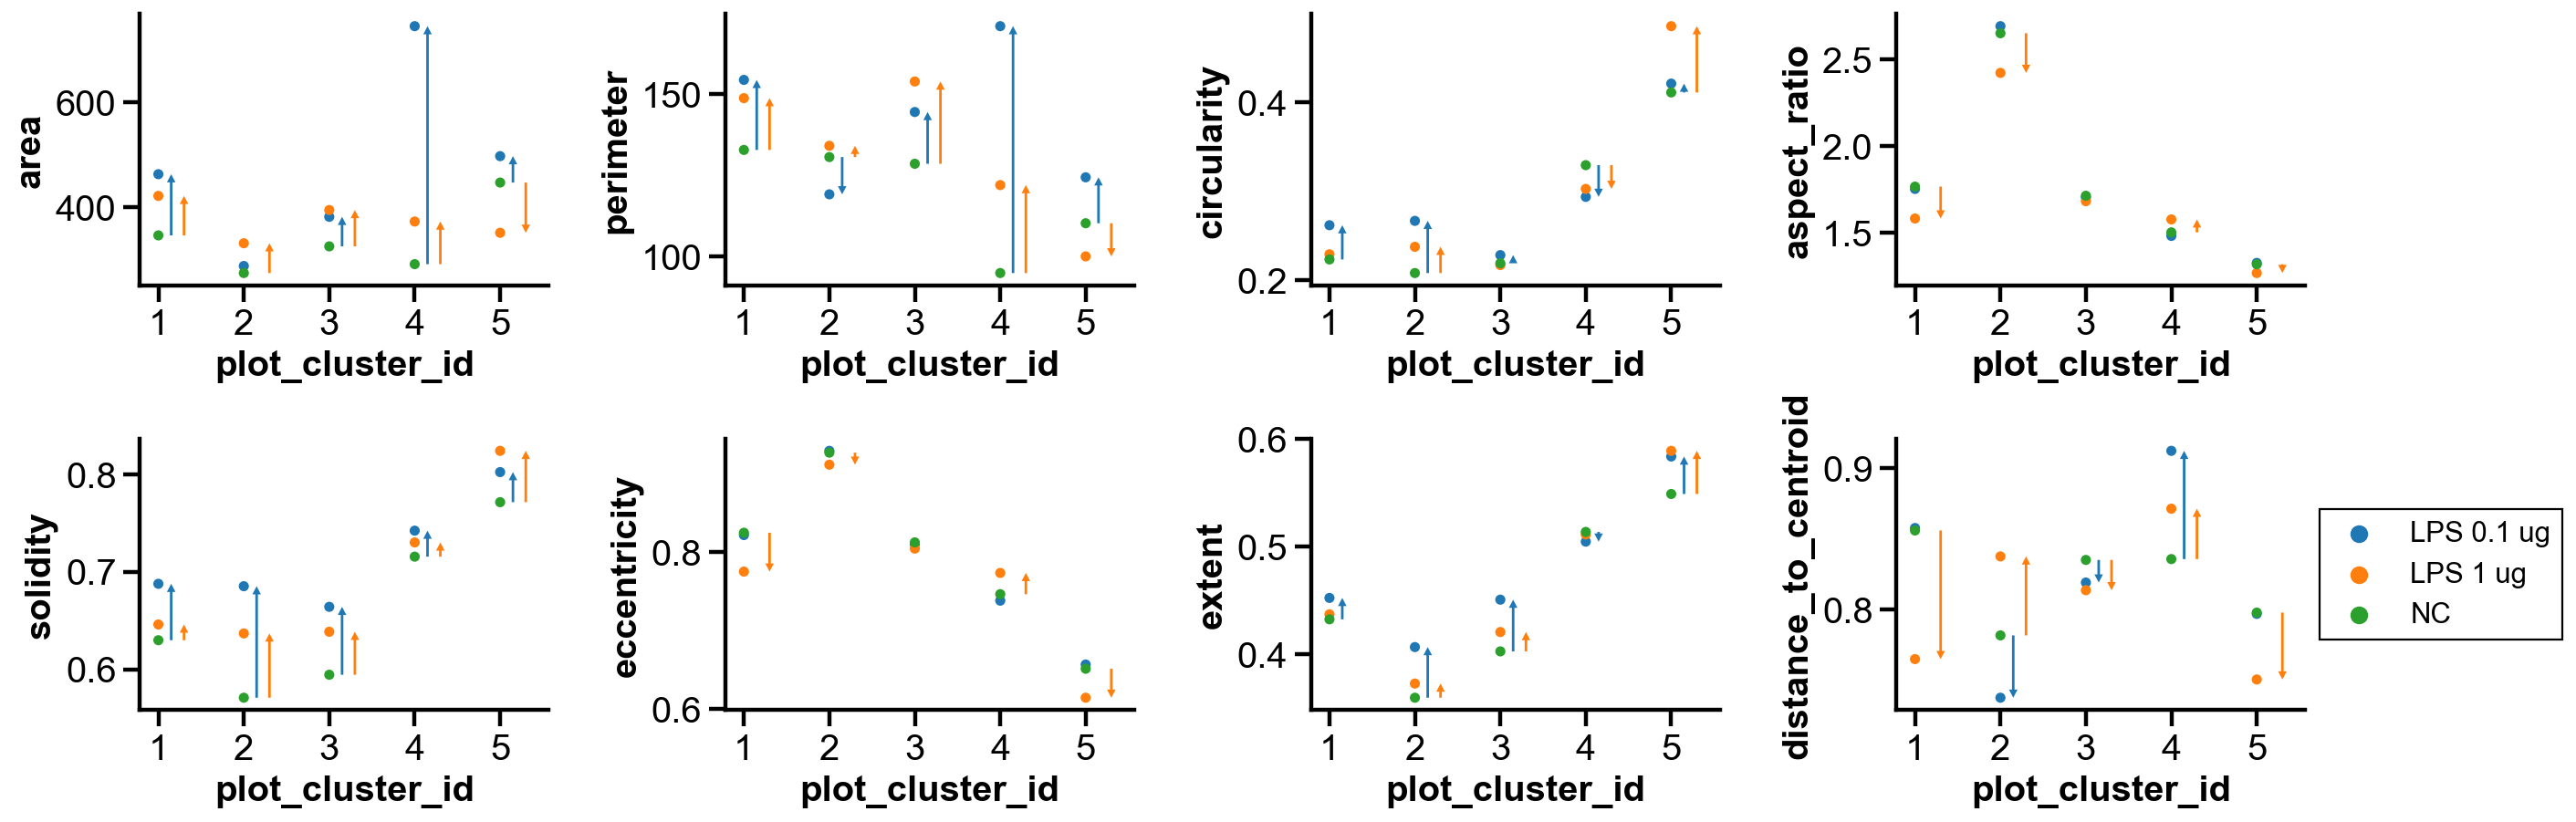

In [134]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(df=injury_df, 
                                feature=properties[i], 
                                category='plot_cluster_id', 
                                controlled_category='treatment', 
                                init_controlled_category='NC', 
                                ax=axs[row_i, col_i])
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes in response to injury (With serum)

In [29]:
injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (injury_df['treatment'].isin(['LPS 1 ug + Serum', 'NC + Serum']))
injury_df = injury_df[injury_cond]
injury_df.head()

,treatment,plot_cluster_id,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,orientation,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,distance_to_centroid,other_time
10,LPS 1 ug + Serum,1,9.0,23.0,794.926650,1028.051447,349.0,924.0,640.0,349.0,...,-0.337175,1.0,0.782673,0.709945,0.510526,0.310501,1.606597,0.0,0.795424,0.0
11,LPS 1 ug + Serum,2,31.0,36.0,987.891473,1129.766520,353.0,850.0,504.0,353.0,...,-0.446122,1.0,0.932322,0.660465,0.352500,0.249326,2.765269,1.0,0.757477,0.0
12,LPS 1 ug + Serum,3,9.0,20.0,734.020270,840.581081,302.0,780.0,477.0,302.0,...,-0.352406,1.0,0.810466,0.594315,0.385417,0.223138,1.707108,2.0,0.754583,0.0
13,LPS 1 ug + Serum,4,12.0,15.0,679.882665,703.979951,390.0,898.5,638.0,390.0,...,-0.224030,1.0,0.785975,0.701456,0.476178,0.307981,1.618397,3.0,0.839841,0.0
14,LPS 1 ug + Serum,5,9.0,31.0,864.684472,779.841615,956.0,1786.0,1148.0,956.0,...,-0.045528,1.0,0.656101,0.820896,0.601326,0.438605,1.325078,4.0,0.794892,0.0


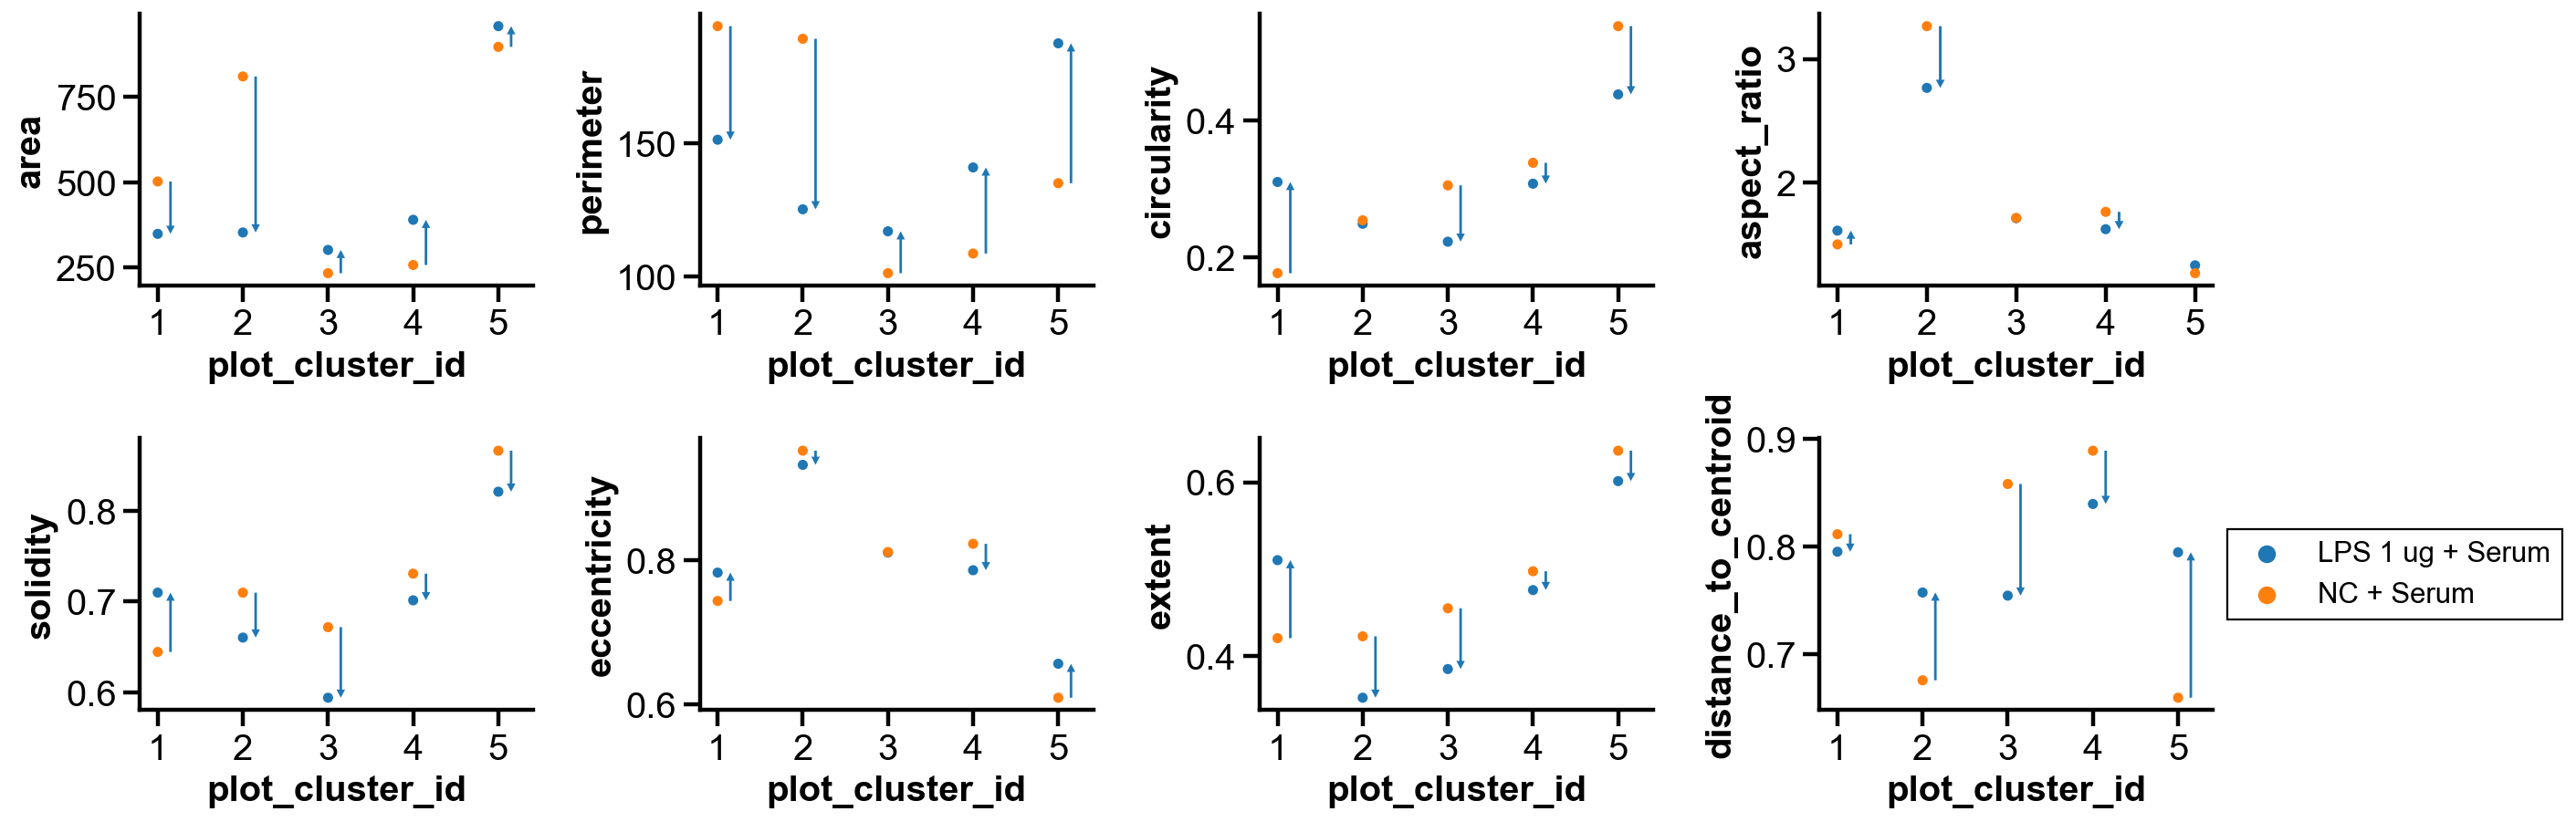

In [30]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(df=injury_df, 
                                feature=properties[i], 
                                category='plot_cluster_id', 
                                controlled_category='treatment', 
                                init_controlled_category='NC + Serum', 
                                ax=axs[row_i, col_i])
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes in response to serum (non-treated control)

In [31]:
injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (injury_df['treatment'].isin(['NC', 'NC + Serum']))
injury_df = injury_df[injury_cond]
injury_df.head()

,treatment,plot_cluster_id,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,orientation,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,distance_to_centroid,other_time
20,NC,1,24.0,28.0,752.727059,638.605442,346.0,864.0,577.0,346.0,...,0.447972,1.0,0.824216,0.629747,0.432609,0.223052,1.765926,0.0,0.855940,0.0
21,NC,2,22.5,19.5,553.284478,812.665286,274.0,740.0,487.5,274.0,...,-0.093206,1.0,0.926096,0.570827,0.359774,0.207775,2.650724,1.0,0.782013,0.0
22,NC,3,22.0,27.0,630.905518,565.561358,325.0,836.0,552.0,325.0,...,0.227535,1.0,0.811955,0.594382,0.402838,0.218761,1.713170,2.0,0.835189,0.0
23,NC,4,24.0,30.0,735.364184,824.755075,291.0,516.5,367.5,291.0,...,0.065631,1.0,0.746032,0.715405,0.513805,0.328964,1.501989,3.0,0.835798,0.0
24,NC,5,19.0,29.5,619.514164,976.653292,447.0,805.0,543.0,447.0,...,-0.244252,1.0,0.651171,0.771226,0.549054,0.410613,1.317692,4.0,0.798075,0.0


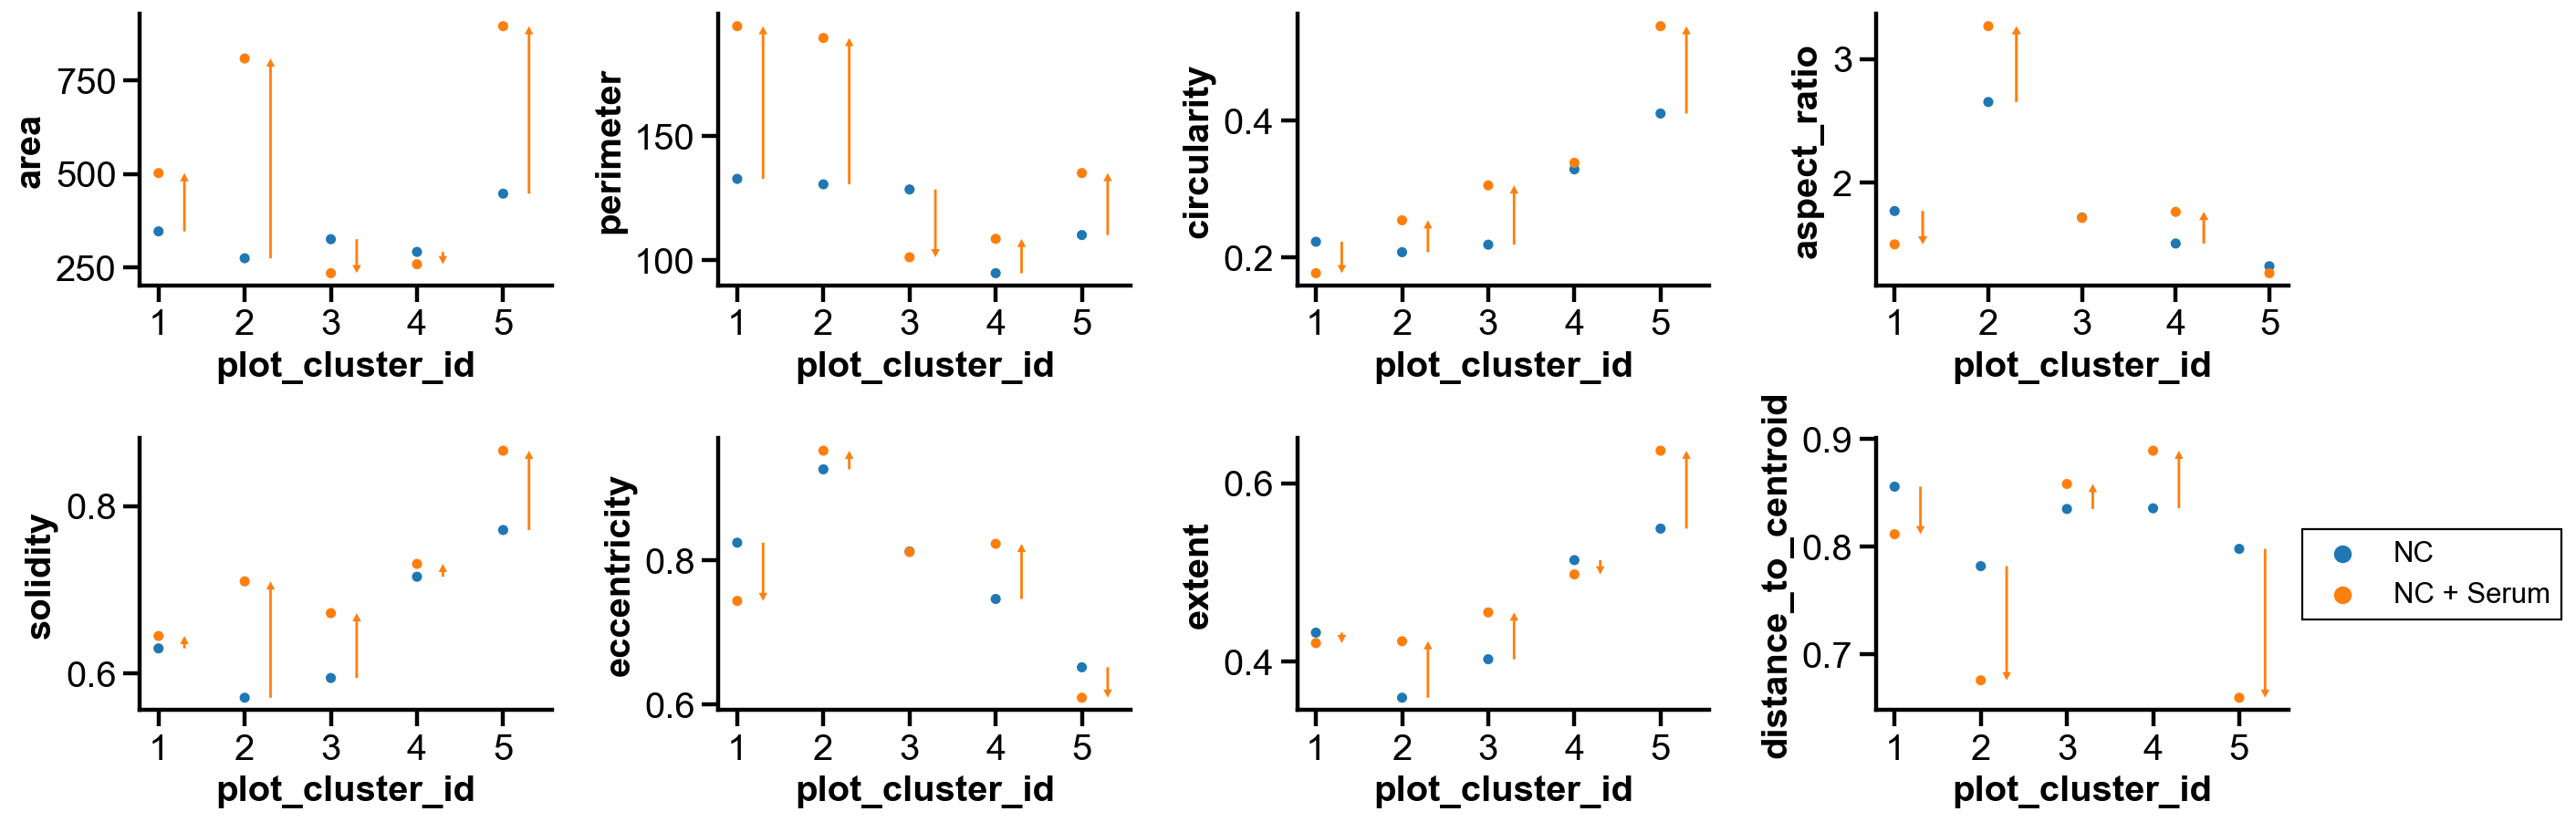

In [32]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(df=injury_df, 
                                feature=properties[i], 
                                category='plot_cluster_id', 
                                controlled_category='treatment', 
                                init_controlled_category='NC', 
                                ax=axs[row_i, col_i])
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes in response to serum (LPS)

In [33]:
injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (injury_df['treatment'].isin(['LPS 1 ug + Serum', 'LPS 1 ug']))
injury_df = injury_df[injury_cond]
injury_df.head()

,treatment,plot_cluster_id,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,orientation,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,distance_to_centroid,other_time
5,LPS 1 ug,1,14.0,39.0,937.566412,628.646280,421.5,952.0,656.0,421.5,...,-0.118853,1.0,0.774760,0.645879,0.437255,0.228845,1.581985,0.0,0.765309,0.0
6,LPS 1 ug,2,14.0,32.0,632.415730,849.560000,331.0,820.0,526.0,331.0,...,0.226870,1.0,0.910794,0.636704,0.372932,0.237263,2.422124,1.0,0.837667,0.0
7,LPS 1 ug,3,14.0,25.0,729.219993,712.956118,394.5,899.0,624.5,394.5,...,0.173457,1.0,0.804031,0.638440,0.420801,0.216725,1.681847,2.0,0.813849,0.0
8,LPS 1 ug,4,14.0,41.0,812.965113,703.696592,372.5,726.5,508.5,372.5,...,0.030041,1.0,0.773065,0.729957,0.511474,0.302263,1.576666,3.0,0.871312,0.0
9,LPS 1 ug,5,14.0,42.0,885.500000,800.697068,351.0,598.0,418.0,351.0,...,-0.110104,1.0,0.614293,0.823834,0.589147,0.485072,1.267302,4.0,0.750943,0.0


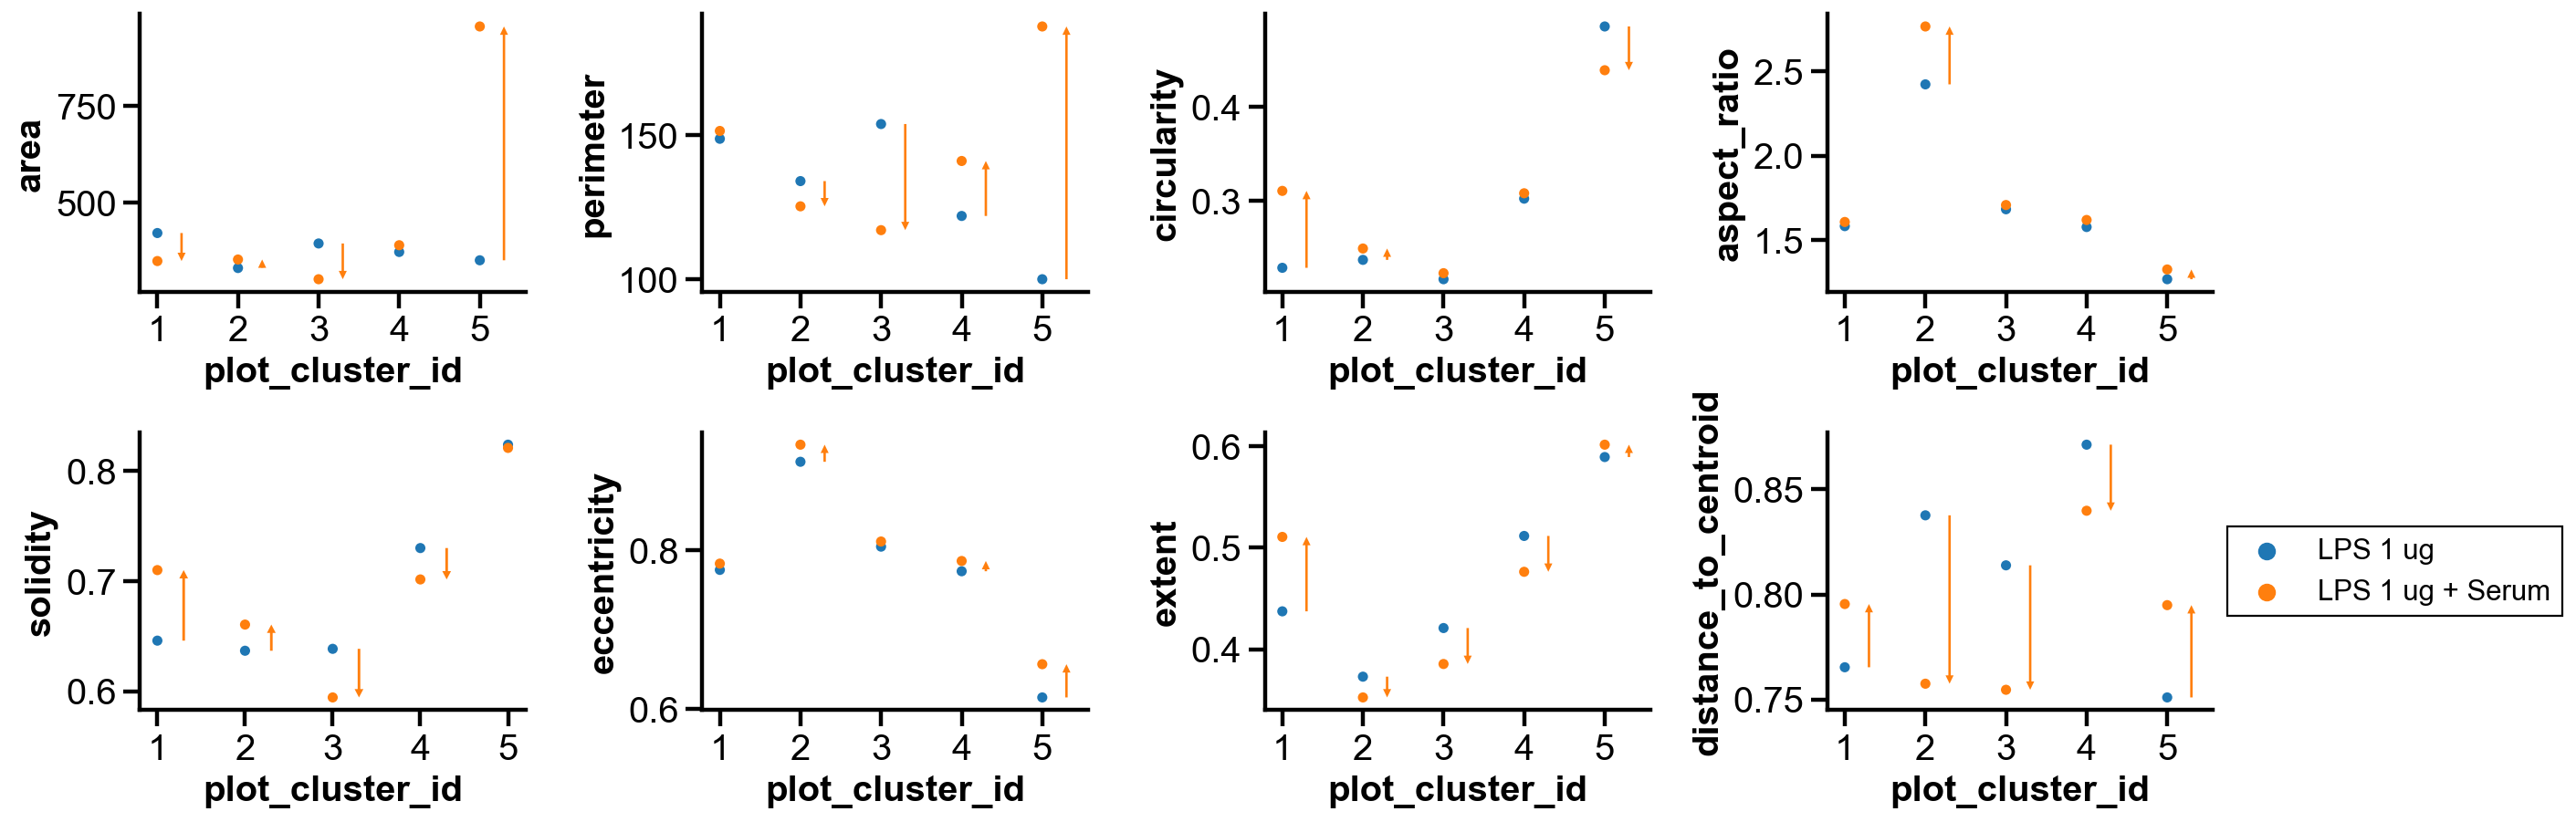

In [34]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(df=injury_df, 
                                feature=properties[i], 
                                category='plot_cluster_id', 
                                controlled_category='treatment', 
                                init_controlled_category='LPS 1 ug', 
                                ax=axs[row_i, col_i])
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [35]:
injury_df = apply_properties_df.groupby(by=['treatment', 'treatment_time']).agg('median').reset_index()
# injury_cond = (injury_df['treatment'].isin(['LPS 1 ug + Serum', 'LPS 1 ug']))
# injury_df = injury_df[injury_cond]
injury_df

,treatment,treatment_time,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,plot_cluster_id,distance_to_centroid,other_time
0,LPS 0.1 ug,24 h,11.0,34.0,666.653846,773.546903,462.0,1020.0,685.0,462.0,...,1.0,0.775660,0.717593,0.485880,0.295425,1.584407,2.0,3.0,0.818015,0.0
1,LPS 0.1 ug,72 h,12.0,4.0,857.304636,142.898089,157.0,406.0,247.0,157.0,...,1.0,0.935377,0.621739,0.415344,0.279675,2.827646,1.0,2.0,0.737230,0.0
2,LPS 1 ug,24 h,14.0,39.5,793.507795,800.872183,391.0,800.0,536.5,391.0,...,1.0,0.773154,0.713164,0.487243,0.293837,1.576752,2.0,3.0,0.816784,0.0
3,LPS 1 ug,72 h,18.0,12.5,887.615095,547.454068,288.5,654.5,447.0,288.5,...,1.0,0.814098,0.613660,0.413166,0.219526,1.722607,2.0,3.0,0.822895,0.0
4,LPS 1 ug + Serum,24 h,12.0,25.5,836.945484,874.202133,371.5,926.0,666.0,371.5,...,1.0,0.793112,0.707797,0.482910,0.288381,1.641832,2.0,3.0,0.807037,0.0
5,LPS 10 ug,24 h,30.0,6.5,710.282406,437.972117,283.5,561.5,391.0,283.5,...,1.0,0.766923,0.738708,0.510879,0.360132,1.558266,2.0,3.0,0.868388,0.0
6,NC,24 h,24.0,31.0,647.469622,820.137639,330.0,808.0,509.0,330.0,...,1.0,0.807070,0.645116,0.420175,0.247508,1.693731,2.0,3.0,0.813003,0.0
7,NC,72 h,17.0,4.0,538.436856,573.007905,305.0,725.0,506.0,305.0,...,1.0,0.868667,0.632653,0.440341,0.242954,2.018587,1.0,2.0,0.859087,0.0
8,NC + Serum,24 h,20.0,18.0,424.493578,641.539894,537.0,1073.0,766.0,537.0,...,1.0,0.764935,0.727273,0.501892,0.328600,1.552537,2.0,3.0,0.776493,0.0


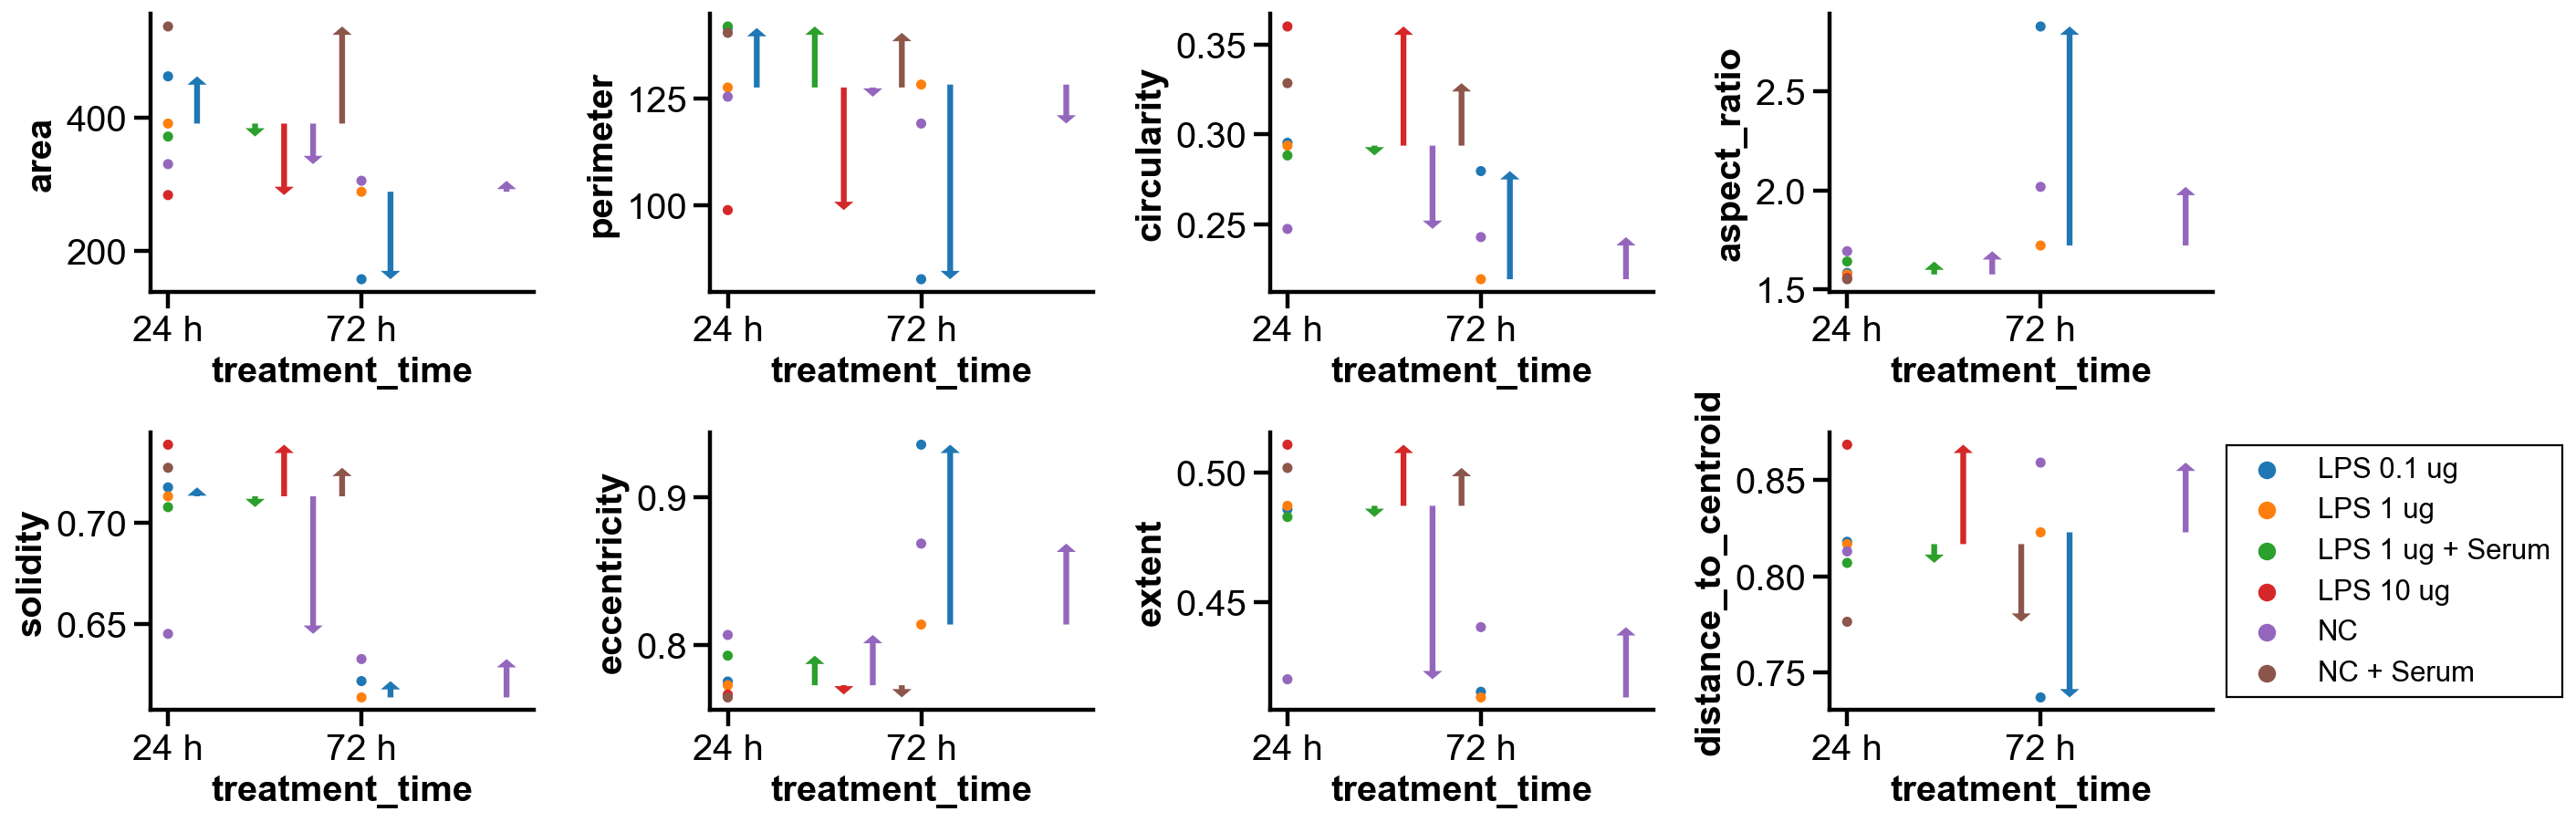

In [36]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(df=injury_df, 
                                feature=properties[i], 
                                category='treatment_time', 
                                controlled_category='treatment', 
                                init_controlled_category='LPS 1 ug', 
                                ax=axs[row_i, col_i])
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

### Heatmap

In [122]:
# treatment_cond = apply_properties_df['treatment'].isin(['NC', 'NC + Serum'])
# treatment_cond = apply_properties_df['treatment'].isin(['LPS 1 ug', 'LPS 1 ug + Serum'])
# treatment_cond = apply_properties_df['treatment'].isin(['NC', 'LPS 0.1 ug', 'LPS 1 ug', 'LPS 10 ug'])  # 10 ug has small sample size
treatment_cond = apply_properties_df['treatment'].isin(['NC', 'LPS 0.1 ug', 'LPS 1 ug'])  # interesting
time_cond = apply_properties_df['treatment_time'] == '24 h'
heatmap_df = apply_properties_df[treatment_cond & time_cond]
count = heatmap_df.groupby(by=['plot_cluster_id', 'treatment']).size().unstack(level=0)
count = count.reindex(index=['NC', 'LPS 0.1 ug', 'LPS 1 ug'])
count

plot_cluster_id,1,2,3,4,5
treatment,,,,,
NC,37,38,40,25,36
LPS 0.1 ug,42,32,36,31,58
LPS 1 ug,63,59,76,66,104


In [123]:
distribution = count.div(count.sum(axis=1), axis=0)*100

In [124]:
np.quantile(distribution, 0.05)

15.165886249428963

In [125]:
np.quantile(distribution, 0.95)

28.526327288616997

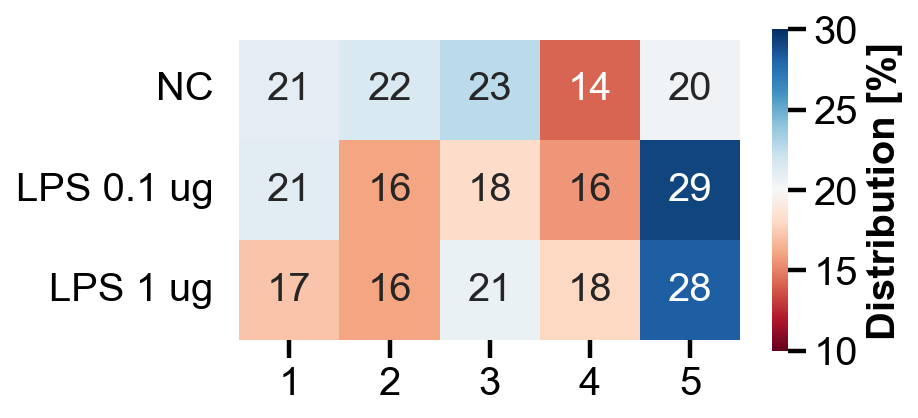

In [150]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(
    distribution, 
    annot=True, 
    cmap='RdBu',
    yticklabels=True,
    vmin=20-10, 
    vmax=20+10,
    ax=ax,
    cbar=True,
    square=True,
    cbar_kws={'label': 'Distribution [%]'},
)
ax.set_xlabel('')
# ax.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(left=None)
plt.tight_layout()
plt.savefig('LPS-heatmap.png', dpi=1000)

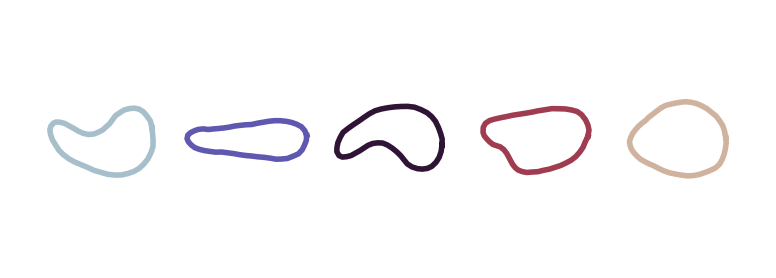

In [130]:
vp.plot.plot_contours(vampire_model, lw=2.5)
plt.savefig('LPS-shape-modes.png', dpi=1000)

In [174]:
treatment_cond = apply_properties_df['treatment'].isin(['NC', 'LPS 0.1 ug', 'LPS 1 ug'])  # interesting
time_cond = apply_properties_df['treatment_time'] == '24 h'
heatmap_df = apply_properties_df[treatment_cond & time_cond]
perimeter_df = heatmap_df.pivot_table('perimeter', 'treatment', 'plot_cluster_id')
perimeter_df = perimeter_df.reindex(index=['NC', 'LPS 0.1 ug', 'LPS 1 ug'])
perimeter_df

plot_cluster_id,1,2,3,4,5
treatment,,,,,
NC,187.120754,191.072586,195.532182,157.772974,152.338429
LPS 0.1 ug,187.488156,150.385806,181.250446,185.579000,134.845231
LPS 1 ug,168.843419,176.237053,183.864718,156.017987,123.227222


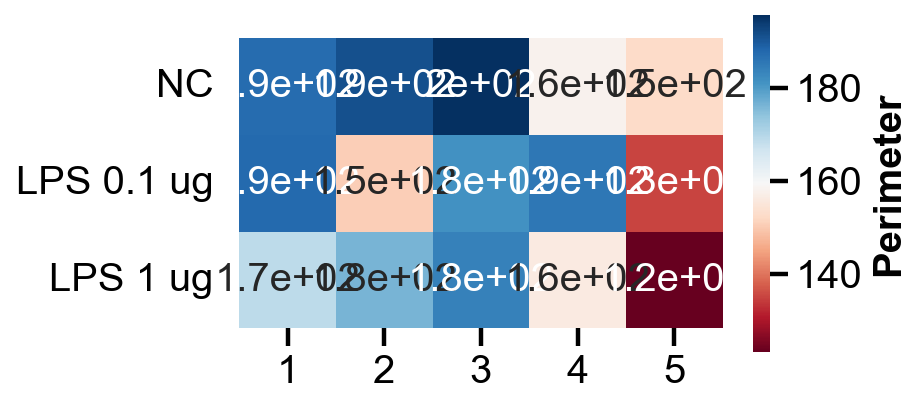

In [175]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(
    perimeter_df, 
    annot=True, 
    cmap='RdBu',
    yticklabels=True,
    # vmin=0.35-0.1, 
    # vmax=0.35+0.1,
    ax=ax,
    cbar=True,
    square=True,
    cbar_kws={'label': 'Perimeter'},
)
ax.set_xlabel('')
# ax.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(left=None)
plt.tight_layout()
# plt.savefig('LPS-heatmap.png', dpi=1000)

In [209]:
injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (~injury_df['treatment'].isin(['LPS 1 ug + Serum', 'NC + Serum', 'LPS 10 ug']))
injury_df = injury_df[injury_cond]
cond = injury_df['treatment'] == 'LPS 0.1 ug'
injury_df.loc[cond, 'treatment'] = 'LPS 0.1 μg'
cond = injury_df['treatment'] == 'LPS 1 ug'
injury_df.loc[cond, 'treatment'] = 'LPS 1 μg'
injury_df.head()

,treatment,plot_cluster_id,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,...,orientation,euler_number,eccentricity,solidity,extent,circularity,aspect_ratio,cluster_id,distance_to_centroid,other_time
0,LPS 0.1 μg,1,12.0,31.0,606.731967,871.650903,463.0,1088.0,775.0,463.0,...,0.266918,1.0,0.821240,0.687589,0.452494,0.261495,1.752592,0.0,0.857696,0.0
1,LPS 0.1 μg,2,11.0,25.0,632.665298,912.488893,287.5,718.0,489.0,287.5,...,0.228262,1.0,0.928411,0.685114,0.406828,0.266378,2.691592,1.0,0.738088,0.0
2,LPS 0.1 μg,3,26.0,37.0,666.357707,707.425651,381.5,804.0,571.0,381.5,...,0.160502,1.0,0.809554,0.663990,0.450879,0.227928,1.703513,2.0,0.819252,0.0
3,LPS 0.1 μg,4,26.0,34.0,702.295288,599.532275,746.0,1332.0,970.0,746.0,...,0.200600,1.0,0.737811,0.742036,0.504808,0.293346,1.481466,3.0,0.912077,0.0
4,LPS 0.1 μg,5,11.0,37.0,718.125930,662.744934,497.5,914.0,609.0,497.5,...,0.068106,1.0,0.656548,0.802061,0.583899,0.420576,1.325770,4.0,0.797190,0.0


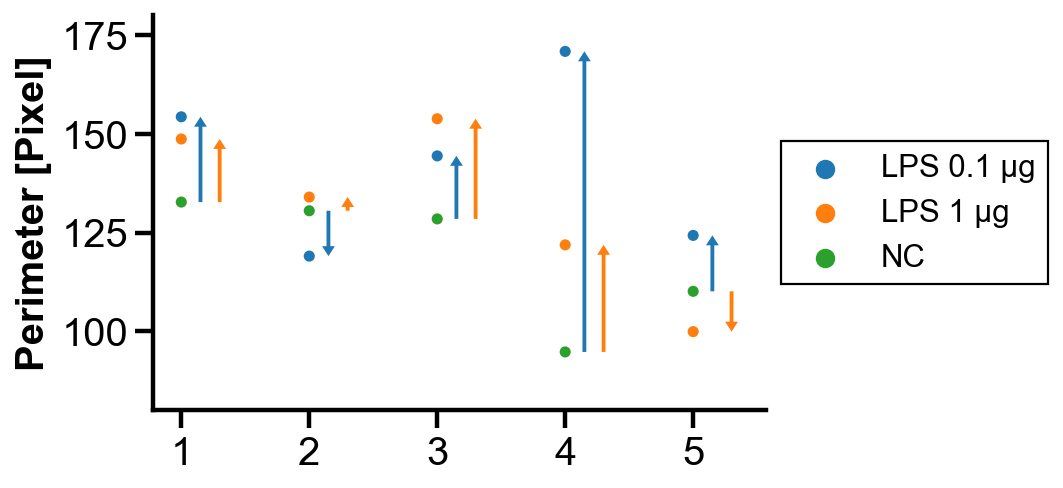

In [210]:
fig, ax = plt.subplots(figsize=(7, 3.5))
plot_basline_change(df=injury_df, 
                    feature='perimeter', 
                    category='plot_cluster_id', 
                    controlled_category='treatment', 
                    init_controlled_category='NC', 
                    ax=ax)
ax.set_ylim(80, 180)
ax.set_xlabel('')
ax.set_ylabel('Perimeter [Pixel]')
plt.tight_layout()
plt.savefig('LPS-perimeter.png', dpi=1000)

In [226]:
treatment_cond = apply_properties_df['treatment'].isin(['NC', 'LPS 0.1 ug', 'LPS 1 ug'])
heatmap_df = apply_properties_df[treatment_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
distribution_df = distribution.T.reset_index().melt(id_vars=['plot_cluster_id'], var_name='treatment', value_name='distribution')

injury_df = apply_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (~injury_df['treatment'].isin(['LPS 1 ug + Serum', 'NC + Serum', 'LPS 10 ug']))
injury_df = injury_df[injury_cond]
# cond = injury_df['treatment'] == 'LPS 0.1 ug'
# injury_df.loc[cond, 'treatment'] = 'LPS 0.1 μg'
# cond = injury_df['treatment'] == 'LPS 1 ug'
# injury_df.loc[cond, 'treatment'] = 'LPS 1 μg'
# injury_df.head()

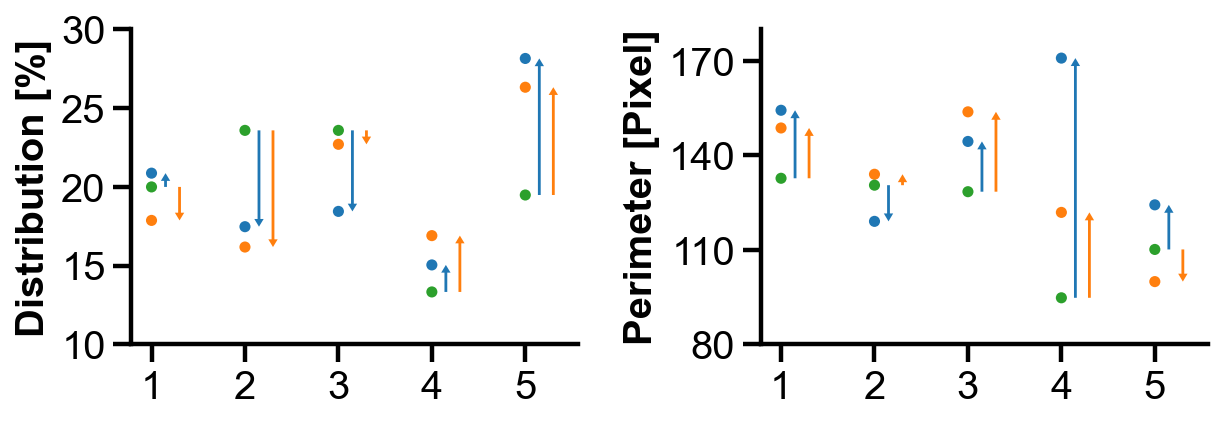

In [242]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_basline_change(df=distribution_df, 
                    feature='distribution', 
                    category='plot_cluster_id', 
                    controlled_category='treatment', 
                    init_controlled_category='NC', 
                    ax=axs[0])
axs[0].set_ylim(10, 30)
axs[0].set_yticks(np.arange(10, 31, 5))
axs[0].set_xlabel('')
axs[0].set_ylabel('Distribution [%]')
axs[0].get_legend().remove()

plot_basline_change(df=injury_df, 
                    feature='perimeter', 
                    category='plot_cluster_id', 
                    controlled_category='treatment', 
                    init_controlled_category='NC', 
                    ax=axs[1])
axs[1].set_ylim(80, 180)
axs[1].set_yticks(np.arange(80, 181, 30))
axs[1].set_xlabel('')
axs[1].set_ylabel('Perimeter [Pixel]')
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('LPS-variability.png', dpi=1000)